# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 2. Loading a pre-processed data set

In [2]:
path = './dataset/toyset/'
filename = 'processed_toyset.csv'
df = pd.read_csv(path + filename)

#### Define dataset row/column sizes to begin with

In [3]:
# df.loc[:, 'gbpusd'] = df.loc[:, 'gbpusd']*50
# df.loc[:, 'gbpjpy'] = df.loc[:, 'gbpjpy']*3
# df.loc[:, 'usdjpy'] = df.loc[:, 'usdjpy']*3

In [4]:
nrow = 3
ncol = 3

In [5]:
proc_covar = 0.0001**2*np.identity(nrow)
post_covar = proc_covar
meas_covar = 0.0003**2*np.identity(nrow)
pred_covar = meas_covar
ident = np.identity(nrow)

In [6]:
state_old = np.ones((3, 1), dtype=np.float64)
emit_mat = np.array([[1., -1, 0.],
                      [1.,  0, -1.],
                      [0., -1., 1.],
                      ], dtype=np.float64)
obs_mat = df.drop(['timestamp', 'time_gap'], axis=1)
obs_mat = obs_mat.to_numpy()
time_gap = df.time_gap.to_numpy().reshape(-1,1)

latent_states = np.empty(shape=(df.shape[0], nrow), dtype=np.float64)
predicted_obs = np.empty(shape=(df.shape[0], nrow), dtype=np.float64)

## Kalman updates

#### Assumptions:
- the order of measurements is GBPJPY, GBPUSD, USDJPY.
- the order of latent variables is GBP, JPY, USD.

In [7]:
ccy_list = ['gbpjpy', 'gbpusd', 'usdjpy']
latent_cols = ['GBP', 'JPY', 'USD']

In [8]:
for i in range(df.shape[0]):
    post_covar = post_covar + time_gap[i]*proc_covar

    # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
    innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
    innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
    kalman_gain = post_covar@(emit_mat.T)@np.linalg.inv(innovation_covar)

    # We transpose (kalman_gain@innovation) from (3,) to (3,1)
    state_new = state_old + (kalman_gain@innovation).reshape(-1, 1)
    post_covar = (ident - kalman_gain@emit_mat)@post_covar
    predicted_obs[i] = (emit_mat@state_new).T
    latent_states[i] - state_new.T
    state_old = state_new

#### Remove the oldest timestamp and shift each row upward by one row.
- e.g. If the raw dataset starts from 2019-05-01 00:00:00 at 0th element, predictions would start from 2019-05-01 00:00:01 at 0th element instead ('lead' by one minute)

In [9]:
new_idx = df.timestamp.shift(-1).to_numpy().reshape(-1, 1)
predictions = np.hstack((new_idx, predicted_obs))
latent_estimates = np.hstack((new_idx, latent_states))

In [10]:
assert predictions.shape[0] == predicted_obs.shape[0], "We have some data loss."
assert latent_estimates.shape[0] == latent_states.shape[0], "We have some data loss."

#### Convert arrays to DataFrame instances

In [11]:
predictions = pd.DataFrame(predictions, columns=['timestamp'] + ccy_list)
latent_estimates = pd.DataFrame(latent_estimates,
                                columns=['timestampe'] + latent_cols)

## How good are the predictions?

#### It's worse than the baseline. Let's see what's going on:

As we expected, currency exchange rates are extremely volatile, and our naive approach fails. Then again, the covariance matrices are not estimated in this case, and there may be a setting that works better. But on the bright side, the graph of currency intrinsic values is really neat:

## Parameter Estimation: EM

So the goal of the project is to build an adaptive Kalman Filter. However, the problem is impossible at our current level, so we have to do a middle ground. A Kalman Smoother allows us to estimate the covariance matrices through the EM algorithm, but it requires using future data to predict the past. By combining a Kalman Smoother with PSIS detailed in the next section, we construct an algorithm to do filtering in a heuristic fashion.

### E step
- The forward pass propagates through the system, given fixed covariance matrices.
- It outputs both the predicted states and the predicted measurements.

In [12]:
ident

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [13]:
def forward_pass(data, initial_state, emit_mat, meas_covar, proc_covar, post_covar):
    '''
    Parameters:
      data(DataFrame, ): a (batch) dataset
    '''
    obs_mat = data.drop(['timestamp', 'time_gap'], axis=1)
    obs_mat = obs_mat.to_numpy()
    time_gap = data.time_gap.to_numpy().reshape(-1,1)

    latent_states = np.empty((data.shape[0], nrow))
    predicted_obs = np.empty((data.shape[0], nrow))

    state_old = initial_state    

    for i in range(data.shape[0]):
        post_covar = post_covar + time_gap[i]*proc_covar

        # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
        innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
        innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
        try:
            kalman_gain = post_covar@(emit_mat.T)@np.linalg.inv(innovation_covar)
        except:
            print(i, 'error at kalman')
            print('post_covar', post_covar, 'dtype', post_covar.dtype)
            print('emit_mat.T', emit_mat.T, 'dtype', emit_mat.dtype)
            print('innovation_covar', innovation_covar, 'dtype', innovation_covar.dtype)
            print('np.linalg.inv(innovation_covar)', np.linalg.inv(innovation_covar))

        # We transpose (kalman_gain@innovation) from (3,) to (3,1)
        state_new = state_old.reshape(-1, 1) + (kalman_gain@innovation).reshape(-1, 1)
        post_covar = (ident - kalman_gain@emit_mat)@post_covar
        predicted_obs[i] = (emit_mat@state_new).T
        latent_states[i] = state_new.T
        state_old = state_new
        
    new_idx = data.timestamp.shift(-1).to_numpy().reshape(-1, 1)
    predicted_obs = np.array(predicted_obs)
    latent_states = np.array(latent_states)
    predictions = np.hstack((new_idx, predicted_obs))
    predictions = np.hstack((predictions, time_gap))
    latent_estimates = np.hstack((new_idx, latent_states))
    latent_estimates = np.hstack((latent_estimates, time_gap))
    
    return predictions, latent_estimates, post_covar, innovation_covar
    

### M step

In [14]:
def update_proc_scale(latent_estimates):
    '''
    Takes the scale matrix of the propagated states.
    But we have to take into account the uneven time gaps.
    '''
    # drop any row with na
#     latent_estimates = latent_estimates.dropna(how='any')
    latent_estimates = latent_estimates[~pd.isna(latent_estimates[:,0]),:]
    time_gap = latent_estimates[:,-1]
    
    # drop two columns
#     latent_estimates = latent_estimates.drop(['timestamp', 'time_gap'], axis=1)
    latent_estimates = latent_estimates[:,1:-1]

    sample_means = [np.average(latent_estimates[:,i], weights=time_gap) for i in range(len(latent_cols))]
    latent_estimates = latent_estimates - sample_means
    
    return ((latent_estimates.T)@latent_estimates).astype(np.float64)

def update_meas_scale(pred, obs):
    '''
    Gets us the observed scale matrix through (biased) MLE.
    The debiasing is done by supplying the correct df to the invWishart
    '''
#     print('type(pred)', type(pred), pred.shape)
#     print('type(obs)', type(obs), obs.shape)
    pred = pred[~pd.isna(pred[:,0]),:]
    obs_timestamp = obs['timestamp'].dropna(how='any').to_numpy()
    unique_timestamp = np.union1d(pred[:,0], obs_timestamp)

    pred_mat = pred[np.isin(pred[:,0], unique_timestamp)]
    obs_mat = obs[np.isin(obs_timestamp, unique_timestamp)]

    # Convert np to dataframe
    pred_mat = pd.DataFrame(pred_mat, columns=['timestamp'] + ccy_list + ['time_gap'])
    obs_pred_mat = pd.merge(left=obs_mat, right=pred_mat,
                            how='inner', on='timestamp', suffixes=('_obs', '_pred'))

    ccy_list_obs = [ccy+'_obs' for ccy in ccy_list]
    ccy_list_pred = [ccy+'_pred' for ccy in ccy_list]

    error_mat = np.array(obs_pred_mat[ccy_list_pred], dtype=float) - np.array(obs_pred_mat[ccy_list_obs], dtype=float) 
    return (error_mat.T)@error_mat

In [15]:
# check.append(update_proc_covar(check[1]))
# check.append(update_meas_scale(pred=check[0], obs=training[:100]))

### EM (Kalman smoother)

In [26]:
def kalman_smoother(data, prior_state, emit_mat, post_covar, prior_meas_df, prior_meas_scale, prior_proc_df, prior_proc_scale):
    '''
    Runs the smoother on a time block through EM
    '''
    nrow_data = data.shape[0]
    predicted_measurements, states, post_covar, innovation_covar = \
        forward_pass(data=data, initial_state=prior_state,
                     emit_mat=emit_mat, meas_covar=prior_meas_scale/prior_meas_df,
                     proc_covar=prior_proc_scale/prior_proc_df,
                     post_covar=post_covar)

    post_proc_scale = update_proc_scale(states)
    post_meas_scale = update_meas_scale(pred=predicted_measurements, obs=data)

    old_proc_scale = post_proc_scale*2
    old_meas_scale = post_meas_scale*2

    while np.sqrt(np.sum(((old_proc_scale - post_proc_scale)/nrow_data)**2) +
                  np.sum(((old_meas_scale-post_meas_scale)/nrow_data)**2)) > 10**(-12):
        
        print(np.sum(((old_proc_scale - post_proc_scale)/nrow_data)**2 +
                     np.sum(((old_meas_scale-post_meas_scale)/nrow_data)**2)))

        old_meas_scale = post_meas_scale
        old_proc_scale = post_proc_scale

        predicted_measurements, states, post_covar, innovation_covar = \
            forward_pass(data=data, initial_state=prior_state,
                         emit_mat=emit_mat,
                         meas_covar=post_meas_scale/nrow_data,
                         proc_covar=post_proc_scale/nrow_data,
                         post_covar=post_covar)

        post_proc_scale = update_proc_scale(states)
        post_meas_scale = update_meas_scale(
            pred=predicted_measurements, obs=data)


    post_proc_df = prior_proc_df + nrow_data - emit_mat.shape[1]
    post_meas_df = prior_meas_df + nrow_data - emit_mat.shape[0]
    
    result = {
        'input_data': data,
        'states': states,
        'predicted_measurements': predicted_measurements,
        'post_meas_df': post_meas_df,
        'post_meas_scale': prior_meas_scale + post_meas_scale,
        'post_proc_df': post_proc_df,
        'post_proc_scale': prior_proc_scale + post_proc_scale,
        'post_covar': post_covar,
        'innovation_covar': innovation_covar
    }

    return result

In [17]:
training = df.loc[10001:12000, :]

predictions, states, post_covar, innovation_covar= forward_pass(data=training[:100],
                                    initial_state=np.array([2.7, -2.2, 2.5]),
                                    emit_mat=emit_mat,
                                    meas_covar=0.01*np.identity(nrow),
                                    proc_covar=0.001*np.identity(nrow),
                                    post_covar=0.001*np.identity(nrow))

# Convert to pandas Data Frame
predictions = pd.DataFrame(predictions,
                           columns=['timestamp'] + ccy_list + ['time_gap'])


# check = []
# check.append(predictions)
# check.append(latent_estimates)


In [60]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [61]:
gbpusd_dict = {'gbpusd(pred)':predictions.iloc[20:100, 1].to_numpy(), 
               'gbpusd(training)':training.iloc[20:100, 1].to_numpy()}

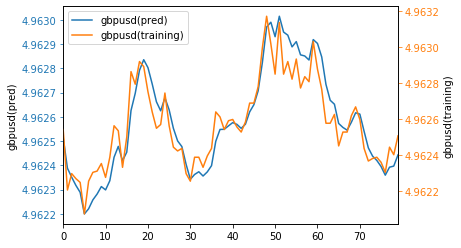

In [62]:
plot_multi(pd.DataFrame(gbpusd_dict))

In [21]:
training[:1000]

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
10001,2019-05-09 17:41:00,4.962901,0.263679,4.699243,1
10002,2019-05-09 17:42:00,4.962299,0.263571,4.698742,1
10003,2019-05-09 17:43:00,4.961774,0.263671,4.698096,1
10004,2019-05-09 17:44:00,4.961781,0.263748,4.698050,1
10005,2019-05-09 17:45:00,4.961795,0.263756,4.698032,1
...,...,...,...,...,...
10996,2019-05-10 10:16:00,4.961907,0.263041,4.698870,1
10997,2019-05-10 10:17:00,4.961977,0.263126,4.698861,1
10998,2019-05-10 10:18:00,4.962103,0.263279,4.698834,1
10999,2019-05-10 10:19:00,4.962040,0.263202,4.698834,1


In [32]:
check_smoother = kalman_smoother(data = training[:1000],
                                 prior_state = np.array([2.7, -2.2, 2.5], dtype=np.float64),
                                 emit_mat=emit_mat,
                                 prior_meas_df=100,
                                 prior_meas_scale=0.01**2*np.identity(emit_mat.shape[1], dtype=np.float64),
                                 prior_proc_df=100,
                                 prior_proc_scale=0.001**2*np.identity(emit_mat.shape[0], dtype=np.float64),
                                 post_covar =0.01*np.identity(emit_mat.shape[0], dtype=np.float64)
                                )

3.1355628680499123e-13
2.1918688789657228e-14
8.300220069773679e-16
1.9804270090211445e-16
5.026319133176936e-17
1.3243564666858579e-17
3.4349907264446747e-18
8.617317158211035e-19
2.1108796032007704e-19
5.12930485524792e-20
1.2551439098285317e-20
3.1411080019817368e-21
8.189952508679795e-22
2.274925305407932e-22
6.881101522900907e-23
2.2955593194551152e-23
8.417265473809589e-24


#### We inspect the Bayes estimates of the covariance matrices:

In [35]:
check_smoother['post_meas_scale'] / (check_smoother['post_meas_df'] - emit_mat.shape[0])

array([[ 1.13607678e-07,  7.57690076e-09,  1.12489416e-08],
       [ 7.57690076e-09,  1.01463000e-07, -1.53571497e-09],
       [ 1.12489416e-08, -1.53571497e-09,  1.05621064e-07]])

In [37]:
check_smoother['post_proc_scale'] / (check_smoother['post_proc_df'] - emit_mat.shape[1])

array([[ 2.10105201e-07, -1.92190032e-07, -1.70010922e-08],
       [-1.92190032e-07,  2.71375613e-07, -7.82715041e-08],
       [-1.70010922e-08, -7.82715041e-08,  9.61866731e-08]])

#### And can visually inspect how the smoother performs on individual currencies:

In [50]:
usdjpy_dict = {'usdjpy(pred)':check_smoother['predicted_measurements'][500:600][:,-2], 
               'usdjpy(training)':check_smoother['input_data'][500:600].loc[:,'usdjpy'].to_numpy()}

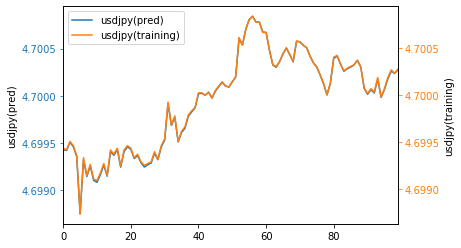

In [63]:
plot_multi(pd.DataFrame(usdjpy_dict))

In [52]:
usdjpy_dict['usdjpy(pred)'] - usdjpy_dict['usdjpy(training)']

array([-5.197076970553383e-06, 6.643028622299596e-06,
       1.9306277074804257e-06, 6.780757235702595e-07,
       4.970597675679755e-06, 1.8489109947950055e-05,
       -1.0650153587477007e-05, 4.599105367653067e-06,
       -3.3281923581540696e-06, 6.33080479595094e-07,
       -2.3510625180023226e-06, -3.4991537729567312e-06,
       -1.6221022969276078e-06, 7.656582014625712e-06,
       -7.1099767167126515e-06, 1.1241390120986239e-06,
       -1.5733490394964633e-06, 3.52770375222633e-06,
       -4.806020152514634e-06, -3.799238701418517e-07,
       1.6024760745025901e-06, 3.3670031918120458e-06,
       -1.8959956875619355e-06, 5.072567245356652e-06,
       -4.432827727995914e-06, 6.021385869914297e-07,
       9.364956543578273e-07, -4.174394850231522e-06,
       8.531495649499732e-06, -1.5700599895751566e-06,
       -2.4723484530753126e-06, -9.573120942185653e-06,
       7.540972586816963e-06, -6.643298640085504e-06,
       6.40675818619485e-06, -2.330992041166269e-06,
       -5.118760

#  PSIS

PSIS is like our alarm that rings whenever the predictions become really bad and we need to update our parameters through smoothing. In particular, we fit the generalized Pareto distribution to the 20% highest importance weights, and if k > 0.7, we refit because we think the variance of the importance weights is infinity.

To do this, we sample 1000 covariance matrices at the start of our forward pass through the filter and hold those fixed (covariance matrices are very expensive to sample)

In [64]:
from scipy.stats import invwishart

In [77]:
prior_proc_df = check_smoother['post_proc_df']
prior_proc_scale = check_smoother['post_proc_scale']
proc_cov_mats = invwishart.rvs(df=prior_proc_df, scale=prior_proc_scale, size=1000)

In [ ]:
def kalman_filter_minibatch(data, emit_mat, initial_state, innovation_covar, post_covar,
                            prior_proc_df, prior_proc_scale,
                            prior_meas_df, prior_meas_scale
                            ):
    batch_size = 1000
    proc_cov_mats = invwishart.rvs(
        df=prior_proc_df, scale=prior_proc_scale, size=batch_size)
    meas_cov_mats = invwishart.rvs(
        df=prior_meas_df, scale=prior_meas_scale, size=batch_size)

    psis_k = 0
    iter_count = 0
    data_count = 0
#     parallel_state = np.expand_dims(initial_state, axis=0)
#     parallel_state = parallel_state.repeat(batch_size, axis=0)
#     innovation_covar_mats = np.expand_dims(innovation_covar, axis=0)
#     innovation_covar_mats = innovation_covar_mats.repeat(batch_size, axis=0)
#     post_cov_mats = np.expand_dims(post_covar, axis=0)
#     post_cov_mats = post_covar.repeat(batch_size, axis=0)

    importance_weights = []

    latent_states = []
    innovation_covar = []
    post_covar = []
    while psis_k < 0.7:
        for i in range(batch_size):
            temp1, temp2, temp3, temp4 = forward_pass(data=data[iter_count],
                                                      initial_state=initial_state,
                                                      emit_mat=emit_mat,
                                                      meas_covar=meas_covar,
                                                      proc_covar=proc_covar,
                                                      post_covar=post_covar
                                                      )
            latent_states.append(temp2[:,emit_mat.shape[0]])
            innovation_covar.append(temp4)
            post_covar.append(temp3)
        
        
        parallel_states = np.array(latent_states)
        innovation_covar_mats = np.array(innovation_covar)
        post_covar_mats = np.array(post_covar)
        
        for i in range(len(parallel_states)):
            
            
            
            
            

In [131]:
post_covar

array([[0.03459531, 0.03320234, 0.03320234],
       [0.03320234, 0.03459531, 0.03320234],
       [0.03320234, 0.03320234, 0.03459531]])

In [ ]:
predictions, states, post_covar, innovation_covar= forward_pass

In [125]:
batch_size=1000
parallel_state = np.expand_dims(initial_state, axis=0)
parallel_state = parallel_state.repeat(batch_size, axis=0)

In [ ]:
for i in range(batch_size):
    temp1, temp2, temp3, temp4 = forward_pass(
        data = data[iter_count],
        initial_state = initial_state,
        emit_mat=emit_mat,
        meas_covar = meas_covar,
        proc_covar = proc_covar,
        post_covar = post_covar
    )

In [87]:
np.ones((1000, len(initial_state)))*initial_state

array([[ 2.7, -2.2,  2.5],
       [ 2.7, -2.2,  2.5],
       [ 2.7, -2.2,  2.5],
       ...,
       [ 2.7, -2.2,  2.5],
       [ 2.7, -2.2,  2.5],
       [ 2.7, -2.2,  2.5]])

In [118]:
a = np.expand_dims(innovation_covar, axis=0)

In [119]:
a.shape

(1, 3, 3)

In [121]:
a.repeat(10, axis=0).shape

(10, 3, 3)

In [114]:
a.shape

(1, 3)

In [105]:
a

array([[ 2.7, -2.2,  2.5]])